In [1]:
%load_ext autoreload
%autoreload 2

# Import packages

In [2]:
from moscot import FusedGW
from ott.geometry.geometry import Geometry
from jax import numpy as jnp

# if trying f64
# from jax.config import config
# config.update("jax_enable_x64", True)

In [3]:
import matplotlib.pyplot as pl
import numpy as np
import ot
from novosparc.reconstruction._GWadjusted import gromov_wasserstein_adjusted_norm

In [4]:
# taken from: https://pythonot.github.io/auto_examples/gromov/plot_fgw.html#sphx-glr-auto-examples-plot-fgw-py
n = 20  # number of points in the first distribution
n2 = 30  # number of points in the second distribution
sig = 1  # std of first distribution
sig2 = 0.1  # std of second distribution

np.random.seed(0)

phi = np.arange(n)[:, None]
xs = phi + sig * np.random.randn(n, 1)
ys = np.vstack((np.ones((n // 2, 1)), 0 * np.ones((n // 2, 1)))) + sig2 * np.random.randn(n, 1)

phi2 = np.arange(n2)[:, None]
xt = phi2 + sig * np.random.randn(n2, 1)
yt = np.vstack((np.ones((n2 // 2, 1)), 0 * np.ones((n2 // 2, 1)))) + sig2 * np.random.randn(n2, 1)
yt = yt[::-1, :]

p = ot.unif(n)
q = ot.unif(n2)

# Visualize the data

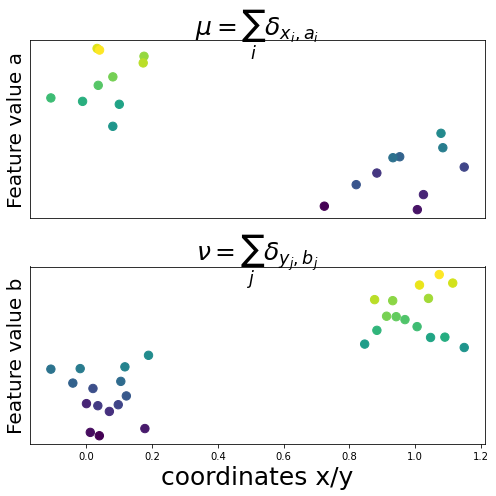

In [5]:
pl.close(10)
pl.figure(10, (7, 7))

pl.subplot(2, 1, 1)

pl.scatter(ys, xs, c=phi, s=70)
pl.ylabel('Feature value a', fontsize=20)
pl.title('$\mu=\sum_i \delta_{x_i,a_i}$', fontsize=25, y=1)
pl.xticks(())
pl.yticks(())
pl.subplot(2, 1, 2)
pl.scatter(yt, xt, c=phi2, s=70)
pl.xlabel('coordinates x/y', fontsize=25)
pl.ylabel('Feature value b', fontsize=20)
pl.title('$\\nu=\sum_j \delta_{y_j,b_j}$', fontsize=25, y=1)
pl.yticks(())
pl.tight_layout()
pl.show()

# Run FGW

## prepare parameters/data

In [6]:
alpha = 1e-3
epsilon = 1e-1
# numerical errors for sinkhorn in POT
# epsilon = 1e-2

C1 = ot.dist(xs)
C2 = ot.dist(xt)
M = ot.dist(ys, yt)
w1 = ot.unif(C1.shape[0])
w2 = ot.unif(C2.shape[0])

## moscot

In [7]:
dtype = np.float32
C1_g = Geometry(cost_matrix=jnp.asarray(C1, dtype=dtype))
C2_g = Geometry(cost_matrix=jnp.asarray(C2, dtype=dtype))
M_g = Geometry(cost_matrix=jnp.asarray(M, dtype=dtype))

It.  |Loss        |Rel. loss   |Abs. loss   |tau         |converged   |eps         
-----------------------------------------------------------------------------------
    1|8.699332e+01|1.000000e+00|8.699332e+01|1.000000e+00|           1|1.000000e-01
    2|4.835174e+01|7.991766e-01|3.864158e+01|1.000000e+00|           1|1.000000e-01
    3|4.408046e+01|9.689741e-02|4.271282e+00|1.000000e+00|           1|1.000000e-01
    4|4.407969e+01|1.748127e-05|7.705688e-04|1.000000e+00|           1|1.000000e-01
    5|4.407910e+01|1.341402e-05|5.912781e-04|1.000000e+00|           1|1.000000e-01
    6|4.408023e+01|2.578888e-05|1.136780e-03|1.000000e+00|           1|1.000000e-01
    7|4.408082e+01|1.324042e-05|5.836487e-04|1.000000e+00|           1|1.000000e-01
    8|4.408087e+01|1.125002e-06|4.959106e-05|1.000000e+00|           1|1.000000e-01
    9|4.408021e+01|1.488486e-05|6.561279e-04|1.000000e+00|           1|1.000000e-01
   10|4.408086e+01|1.462503e-05|6.446838e-04|1.000000e+00|           1|1.000

True

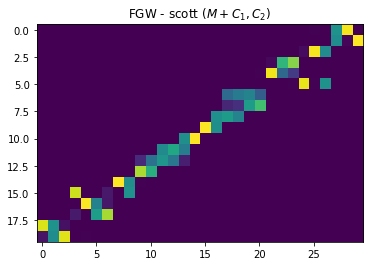

In [12]:
fgwot = FusedGW(alpha=alpha, epsilon=1e-1)
fgwot.fit(C1_g, C2_g, M_g, log=True, n_iters=20)
pl.imshow(fgwot.matrix, cmap='viridis', interpolation='nearest')
pl.title('FGW - scott ($M+C_1,C_2$)')
fgwot.converged

In [13]:
fgwot.converged_sinkhorn?

## novosparc

In [9]:
Gwg = gromov_wasserstein_adjusted_norm(M, C1, C2, alpha_linear=1 - alpha, p=p, q=q,
                                       loss_fun="square_loss", epsilon=epsilon,
                                       random_ini=False, verbose=True)

It.  |Err         
-------------------
    0|1.034371e-01|


Text(0.5, 1.0, 'FGW - novosparc ($M+C_1,C_2$)')

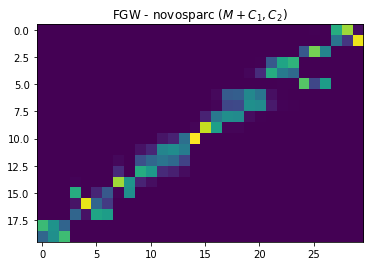

In [10]:
pl.imshow(Gwg, cmap='viridis', interpolation='nearest')
pl.title('FGW - novosparc ($M+C_1,C_2$)')

In [11]:
jnp.max(jnp.abs(fgwot.matrix - Gwg))

DeviceArray(0.01215757, dtype=float32)